# Read data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [7]:
# replace this with the file path on your computer
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)

In [8]:
# don't touch the original df
# df = original_df.copy()

In [9]:
target_classes = df['STAT_CAUSE_DESCR'].unique()

In [10]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Null columns

In [11]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


In [12]:
# null_columns = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
#                 'FIRE_CODE', 'FIRE_NAME',
#                 'ICS_209_INCIDENT_NUMBER',  'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
#                 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
#                 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']

# we will not encode all of them, just encode these:
null_features = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
                         'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                         'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
                         'COUNTY', 'FIPS_CODE', 'FIPS_NAME']



There are five columns that are 99% null, from EDA section, we see that if they are not null, it will help with the prediction of some columns.  
For other features, it seems like encode them as null or not null both have benefits.

In [13]:
# fucntion that will encode this four columns
def null_encoding(df):
  # these columns will be encoded as 1 - null, 0 - not null
  for feature in null_features:
    df['NE-'+feature] = df[feature].isnull().astype(int)
  return df


Little note here: we tried to pass some columns with empty values to the model, since XGB is able to fill in te blank. However, the train error will be lower but the validation error is higher.

# Geo Spacial data

## STATE

During the EDA we found out that being in certain state will affect the distribution of the final label. So what we are going to do is that, for each label, we will find the top k states that is highly correlated to the label, and we will generate a feature that says "is the sample in either of these k states".

In [14]:
state_significance = {}

def train_state_encoders(df):
  # find out for each class which states will have higher than normal percentage of the class instance.
  percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
  cross_Vals = pd.crosstab(df['STATE'], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)

  # For each class, we will encode each state to "how important they are to prediction the class"
  for target_class in target_classes:
    state_significance_per_class = {}
    for state in cross_Vals.index:
      significance = cross_Vals.loc[state, target_class]
      state_significance_per_class[state] = significance
    state_significance[target_class] = state_significance_per_class




In [15]:
train_df = pd.concat([X_train, y_train], axis=1)
train_state_encoders(train_df)

In [16]:
def state_encoding(df):
  for target_class in target_classes:
    df['SE-'+ target_class] = df['STATE'].map(state_significance[target_class])
  return df

# Numerical

## ID Columns

There are three not null ID columns: 'OBJECTID', 'FOD_ID', 'FPA_ID'  
Object id and FOD id should not contain any information, if they do, then it's probably leakage?  
Let's try to add them to the model and see if it helps.
At first glance doesn't really help.

In [17]:
id_columns = ['OBJECTID', 'FOD_ID', 'FPA_ID']


## Fire Size

First try just add in FIRE_SIZE and see what happens: It doesn't help much, we will keep it. Taking the log doesnot really improve it either.

# Time data

## Date, Month, Season

Let's first convert the time to the right format

From EDA we have seen that season, month and day of week really affects the final prediction. So we will add in this data.

In [18]:
# target_classes = df['STAT_CAUSE_DESCR'].unique()
# # Create a figure and axes for the subplots
# fig, axes = plt.subplots(4, 3, figsize=(12, 9))

# # Flatten the axes array for easier iteration
# axes = axes.flatten()

# for i, target_class in enumerate(target_classes):
#   target_class_df = df[df['STAT_CAUSE_DESCR'] == target_class]
#   target_class_counts = target_class_df.groupby(df['DISCOVERY_DOY']).size()
#   target_class_counts.plot(kind='bar', color='blue', ax=axes[i])
#   axes[i].set_title(target_class)
#   axes[i].set_xticks([])
#   axes[i].set_xlabel('')


# plt.show()

The first thing we want to check is the obvious ones:  Firework on July the forth. Alone with Miscellaneous, Children and Campfire.

The second thing is we can see that Arson, debris buring, railroad and children have more instances in april. While Lighning and equipment use have more instances in July. Maybe I should try one hot encoding and frequency encoding on month and season.

We also looked at FIRE_YEAR

Little note here: if we have more time, we can see the correlation between two joint features: (feature_1 = a X feature_2 = b). To be more precise: Summer in Alaska. Somethings like this.   
Another little note, I was planning to put some catagorical data in for XGBoost to do some one hot embedding, but turns out that some fatures (season) will make the overall performance lowers.....  
One more thing we can do is preform a cyclic transformation of week of day or even day of year.

In [19]:
import numpy as np
def time_encoding(df):
  # simple reformatting
  df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M', errors='coerce')
  df['CONT_DATE']= pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format='%H%M', errors='coerce')
  # encode independence day
  df['independence_day'] = (df['DISCOVERY_DATE'].dt.month == 7) & (df['DISCOVERY_DATE'].dt.day.isin([4, 5]))

  # encode month and day of week (weekend or not.)
  df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%B')
  df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%A')
  # notice that these two columns will be frequency encoded in the later section. So the later section depends on the execution of this section.

  # I want to pass fire year as a catagory, just like month and day of week, for onhot encoding
  df['FIRE_YEAR'] = df['FIRE_YEAR'].astype('category')

  # Now I want to see if I can stuff in one more thing: Season. Basically a combination of months.
  # And I will both one hot encode it and frequency encode it
  df['SEASON'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                                          5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                          9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
  # For null time data: Discovery time, control date, control time etc.
  # encode discovery time
  df['DISCOVERY_HOUR'] = df['DISCOVERY_TIME'].dt.hour

  # encode delta time
  df['DISCOVERY_DATETIME'] = pd.to_datetime(df['DISCOVERY_DATE'].astype(str) + ' ' + df['DISCOVERY_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')


  df['CONT_DATETIME'] = pd.to_datetime(df['CONT_DATE'].astype(str) + ' ' + df['CONT_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')

  # Calculate the time difference
  df['DELTA_TIME'] = (df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']).dt.total_seconds()

  # Cyclic transformation for DOY, Month, Week, Hour
  df['SIN_DISCOVERY_DOY'] = np.sin(2*np.pi*df['DISCOVERY_DOY']/366)
  df['COS_DISCOVERY_DOY'] = np.cos(2*np.pi*df['DISCOVERY_DOY']/366)

  df['SIN_MONTH'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)
  df['COS_MONTH'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)

  df['SIN_DAY_OF_WEEK'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)
  df['COS_DAY_OF_WEEK'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)

  df['SIN_HOUR'] = np.sin(2*np.pi*df['DISCOVERY_HOUR']/24)
  df['COS_HOUR'] = np.cos(2*np.pi*df['DISCOVERY_HOUR']/24)
  return df

In [20]:
encoded_time_data = ['independence_day', 'MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'DISCOVERY_HOUR', 'DELTA_TIME',
                     'SIN_DISCOVERY_DOY', 'COS_DISCOVERY_DOY', 'SIN_MONTH', 'COS_MONTH',
                     'SIN_DAY_OF_WEEK', 'COS_DAY_OF_WEEK', 'SIN_HOUR', 'COS_HOUR']

## Null Time Data

It seems like some of the descovery time and contained time are null. In order to solve this problem, denote delta_time = contained_time - discover_time. We can see that there are correlation between delta_time and fire_size, so maybe we can try to imputate this value.   
In EDA, we can see that descovery time and contained time being null have high correlation. So if both time is mising, we can try to drop the rows, and see what would happen.

In [21]:
# not used
def drop_null_time_rows(X, y):
  df = X
  df['STAT_CAUSE_DESCR'] = y
  df = df.dropna(subset=['DISCOVERY_TIME']).copy()
  y = df['STAT_CAUSE_DESCR']
  X = df.drop(columns=['STAT_CAUSE_DESCR'])
  return X, y

It seems like if not drop null rows, XGBoost will preform slightly better by fill in the blank by itself.

Now there are two thing we want to do, first, we want to encode the discovery_time, and then we want to calculate delta time.  
I am thinking for starters, I will encode the discovery time into hours of the day, and preform a cyclic transformation.

The observation is, cyclic transformation on hour doesnot really help with accuracy.

Let's first try to see if we just pass in DISCOVERY_HOUR and DELTA_TIME, what would happen.   
Turns out it helps the model by a little bit.

Finally to add something, we will just add cyclic transformation for DOY, MONTH, Week, Hour, and see what happens

# Catagorical

We will try to use frequency encoding for every thing. Except for null columns and states.

In [22]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']
LC_features = ['FIRE_SIZE_CLASS',
                'NWCG_REPORTING_AGENCY',
                'OWNER_CODE', 'OWNER_DESCR',
                'SOURCE_SYSTEM', 'SOURCE_SYSTEM_TYPE',
               'STATE']
catagorical_time_data = ['MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'SEASON', 'DISCOVERY_HOUR']
catagorical_features = HC_features + LC_features + catagorical_time_data

In [23]:
#  generic function for frequency encoding
from sklearn.preprocessing import LabelEncoder
frequency_encoder_map = {}
def train_frequency_encoders(df):
  for feature in catagorical_features:
    frequency_encoder = df[feature].value_counts(normalize=True)
    frequency_encoder_map[feature] = frequency_encoder

def frequency_encoding(df):
  for feature in catagorical_features:
    le = frequency_encoder_map[feature]
    df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
  return df

Little note here: if just simply pass catagorical data to to XGB will not make it better. I am assuming XGB is using one hot embedding.

# XGBoost

## Preparation

In [24]:
# select features for trainin: This list depends on feature engineering
encoded_catagorical_features = ['FE-' + feature for feature in catagorical_features]
encoded_null_features = ['NE-'+ feature for feature in null_features]
state_encoding_features = ['SE-' + target_class for target_class in target_classes]
selected_features = encoded_catagorical_features + encoded_null_features + state_encoding_features + ['FIRE_SIZE']+ encoded_time_data

In [25]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(y)
def transform_data_for_XGB(X, y, train = False):
  # encode y
  y = target_encoder.transform(y)

  # null encoding
  X = null_encoding(X)

  # encode time data
  X = time_encoding(X)

  # state encoding
  X = state_encoding(X)

  if train==True:
    # train the frequency encoders
    train_frequency_encoders(X)

  # frequency encoding: notice: frequency encoding at the end!
  X = frequency_encoding(X)

  # select feature for training
  X = X[selected_features]

  # change "object" dtypes to "category" types
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})
  return X, y


In [26]:
X_train, y_train = transform_data_for_XGB(X_train, y_train, train=True)
X_val, y_val = transform_data_for_XGB(X_val, y_val)

In [27]:
X_train

,FE-NWCG_REPORTING_UNIT_ID,FE-NWCG_REPORTING_UNIT_NAME,FE-SOURCE_REPORTING_UNIT,FE-SOURCE_REPORTING_UNIT_NAME,FE-FIRE_SIZE_CLASS,FE-NWCG_REPORTING_AGENCY,FE-OWNER_CODE,FE-OWNER_DESCR,FE-SOURCE_SYSTEM,FE-SOURCE_SYSTEM_TYPE,FE-STATE,FE-MONTH,FE-DAY_OF_WEEK,FE-FIRE_YEAR,FE-SEASON,FE-DISCOVERY_HOUR,NE-LOCAL_FIRE_REPORT_ID,NE-LOCAL_INCIDENT_ID,NE-ICS_209_INCIDENT_NUMBER,NE-ICS_209_NAME,NE-MTBS_ID,NE-MTBS_FIRE_NAME,NE-COMPLEX_NAME,NE-DISCOVERY_TIME,NE-CONT_DATE,NE-CONT_DOY,NE-CONT_TIME,NE-COUNTY,NE-FIPS_CODE,NE-FIPS_NAME,SE-Miscellaneous,SE-Arson,SE-Debris Burning,SE-Smoking,SE-Campfire,SE-Equipment Use,SE-Powerline,SE-Lightning,SE-Railroad,SE-Children,SE-Fireworks,SE-Structure,FIRE_SIZE,independence_day,MONTH,DAY_OF_WEEK,FIRE_YEAR,DISCOVERY_HOUR,DELTA_TIME,SIN_DISCOVERY_DOY,COS_DISCOVERY_DOY,SIN_MONTH,COS_MONTH,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_HOUR,COS_HOUR
371756,0.032985,0.032985,0.002740,0.002740,0.497544,0.723358,0.531671,0.531671,0.015738,0.721503,0.034305,0.031248,0.158516,0.049458,0.155491,NaN,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0.677783,1.478053,1.681337,0.813810,0.177474,0.829817,0.391874,0.222093,0.445904,1.470959,0.138962,1.303179,0.50,False,December,Saturday,2001,NaN,NaN,-0.051479,0.998674,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,NaN,NaN
162848,0.016973,0.016973,0.005650,0.008330,0.358310,0.723358,0.172419,0.172419,0.374658,0.721503,0.018580,0.126608,0.135839,0.039723,0.336450,0.060489,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1.029243,0.608090,1.225531,1.038219,1.201481,1.972102,3.403889,0.122110,1.709376,0.929320,2.565720,5.508728,0.25,False,April,Thursday,2015,18.0,11580.0,0.882679,-0.469977,8.660254e-01,-5.000000e-01,0.433884,-0.900969,-1.000000,-1.836970e-16
279467,0.064920,0.064920,0.023535,0.024955,0.115701,0.723358,0.531671,0.531671,0.374658,0.721503,0.082688,0.120191,0.158516,0.060600,0.336450,NaN,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1.478708,0.394179,1.604908,0.905595,0.300654,1.310471,3.691275,0.298114,0.351176,0.309394,0.274956,0.042683,20.00,False,March,Saturday,2006,NaN,NaN,0.991723,0.128398,1.000000e+00,6.123234e-17,-0.974928,-0.222521,NaN,NaN
322716,0.043988,0.043988,0.000013,0.043988,0.497544,0.723358,0.531671,0.531671,0.374658,0.721503,0.047075,0.113536,0.138119,0.060600,0.328855,0.122120,1,0,1,1,1,1,1,0,0,0,0,0,0,0,3.224917,0.761972,0.318800,1.938213,0.346079,0.172423,1.349969,0.411617,0.038553,0.399729,0.038949,0.549807,0.50,False,August,Tuesday,2006,15.0,0.0,-0.685548,-0.728028,-8.660254e-01,-5.000000e-01,0.781831,0.623490,-0.707107,-7.071068e-01
108133,0.007263,0.007263,0.007263,0.007263,0.358310,0.723358,0.531671,0.531671,0.049385,0.721503,0.103311,0.126608,0.137216,0.036653,0.336450,NaN,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1.554128,0.682705,0.318892,1.068325,1.238111,2.592732,0.807367,0.925040,0.195749,1.109916,0.170377,0.387181,0.10,False,April,Friday,2004,NaN,NaN,0.874481,-0.485060,8.660254e-01,-5.000000e-01,-0.433884,-0.900969,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.001593,0.001593,0.001593,0.001593,0.358310,0.723358,0.531671,0.531671,0.049385,0.721503,0.103311,0.056715,0.146471,0.035075,0.179204,NaN,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1.554128,0.682705,0.318892,1.068325,1.238111,2.592732,0.807367,0.925040,0.195749,1.109916,0.170377,0.387181,0.10,False,October,Sunday,1997,NaN,NaN,-0.955211,0.295927,-8.660254e-01,5.000000e-01,-0.781831,0.623490,NaN,NaN
259178,0.004250,0.004250,0.004080,0.004080,0.358310,0.053313,0.172419,0.172419,0.136034,0.276485,0.103311,0.113536,0.144944,0.049458,0.328855,0.044514,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1.554128,0.682705,0.318892,1.068325,1.238111,2.592732,0.807367,0.925040,0.195749,1.109916,0.170377,0.387181,0.10,False,August,Monday,2001,19.0,1800.0,-0.819972,-0.572404,-8.660254e-01,-5.000000e-01,0.000000,1.000000,-0.965926,2.588190e-01
365838,0.003918,0.003918,0.003918,0.003918,0.358310,0.053313,0.172

In [28]:
# save the files to drive, so that we can switch to GPU
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
dump_file(y_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
dump_file(X_val,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
dump_file(y_val, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
dump_file(target_encoder, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


## Training (Can switch to GPU)

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
sample_weights = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/sample_weights')

In [2]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    # "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": True,
    # "eval_metric": auc_ovr,
    #  "n_estimators": 2,
    # "max_cat_to_onehot": 4
    # "colsample_bylevel": 0.7,
    # 'objective':'multi:softmax',  # for multi-class classification
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:2.03266	validation_1-mlogloss:2.03475
[1]	validation_0-mlogloss:1.85245	validation_1-mlogloss:1.85619
[2]	validation_0-mlogloss:1.73672	validation_1-mlogloss:1.74176
[3]	validation_0-mlogloss:1.65500	validation_1-mlogloss:1.66139
[4]	validation_0-mlogloss:1.59538	validation_1-mlogloss:1.60312
[5]	validation_0-mlogloss:1.54996	validation_1-mlogloss:1.55903
[6]	validation_0-mlogloss:1.51393	validation_1-mlogloss:1.52426
[7]	validation_0-mlogloss:1.48500	validation_1-mlogloss:1.49661
[8]	validation_0-mlogloss:1.46109	validation_1-mlogloss:1.47398
[9]	validation_0-mlogloss:1.44218	validation_1-mlogloss:1.45640
[10]	validation_0-mlogloss:1.42697	validation_1-mlogloss:1.44271
[11]	validation_0-mlogloss:1.41301	validation_1-mlogloss:1.43011
[12]	validation_0-mlogloss:1.40202	validation_1-mlogloss:1.42050
[13]	validation_0-mlogloss:1.39221	validation_1-mlogloss:1.41207
[14]	validation_0-mlogloss:1.38384	validation_1-mlogloss:1.40499
[15]	validation_0-mlogloss:1.37629	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [3]:
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')


## Evaluation

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
target_encoder = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


In [2]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')

In [3]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Each Class')
  plt.legend(loc='lower right')
  plt.show()

In [4]:
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8496371006798196

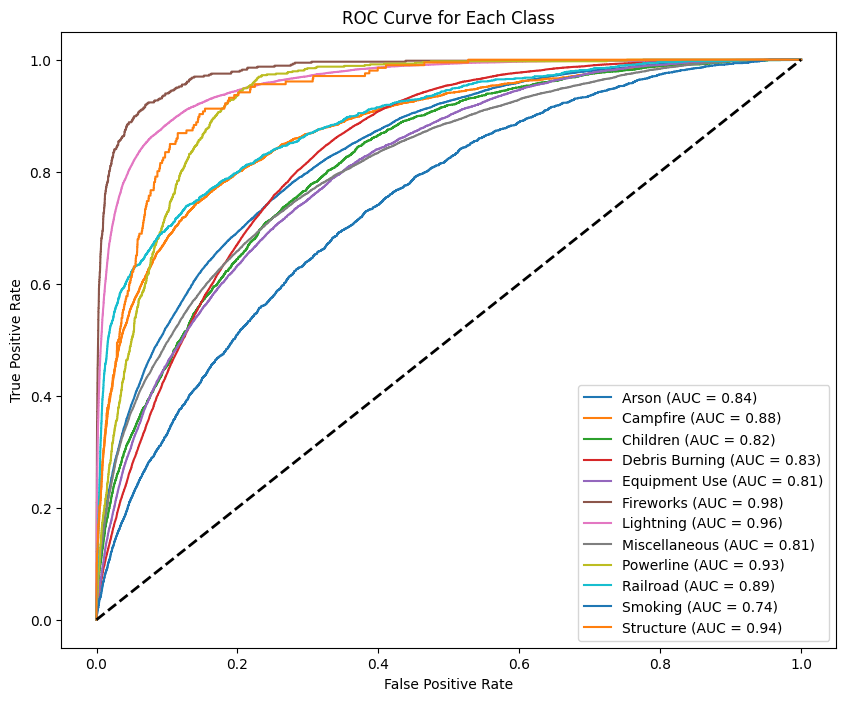

In [5]:
plot_auc_by_class(y_val, y_pred_prob)